# Influence functions for data mislabeling


In this notebook, we will take a closer look at the theory of influence functions with the help of a synthetic dataset. Data mislabeling occurs whenever some examples from a usually big dataset are wrongly-labeled. In real-life this happens fairly often, e.g. as a consequence of human error, or noise in the data. 

Let's consider a classification problem with the following notation:

$$
\begin{align*}
x_i &\in \mathbb{R}^d \\
y_i &\in \{0, 1\} \\
\forall i &\in [ N ]
\end{align*}
$$

In other words, we have a dataset containing $N$ samples, each with label 1 or 0. As typical example you can think of y indicating whether a patient has a disease based on some feature representation $x$. 

Let's now introduce a toy model that will help us delve into the theory and practical utility of influence functions. We will assume that $y$ is a Bernoulli binary random variable while the input $x$ is d-dimensional Gaussian distribution which depends on the label $y$. More precisely:

$$
y_i \sim \text{Ber}\left (0.5 \right) \\
x_i \sim \mathcal{N}\left ((1 - y_i) \mu_1 + y_i \mu_2, \sigma^2 I \right),
$$

with fixed means and diagonal covariance. Implementing the sampling scheme in python is straightforward and can be achieved by first sampling $y$ and afterward $x$.

The following code snippet generates the aforementioned dataset.

In [1]:
import numpy as np
from valuation.influence.model_wrappers import TorchBinaryLogisticRegression
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import AdamW, lr_scheduler
from valuation.utils.dataset import synthetic_classification_dataset

num_samples = 10000
num_features = 2
sigma = 0.2
means = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])

num_classes = len(means)
train_ds, val_ds, test_ds = synthetic_classification_dataset(means, sigma, num_samples, train_size=0.7, test_size=0.2)

/Users/fabio/miniconda3/envs/data_shapley/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Given the simplicity of the dataset, we can calculate exactly the optimal decision boundary(that which maximizes our accuracy). The following code maps a continuous line of z values to a 2-dimensional vector in feature space (More details are in the appendix to this notebook.)

In [2]:
from valuation.utils.dataset import decision_boundary_fixed_variance_2d

decision_boundary_fn = decision_boundary_fixed_variance_2d(means[0], means[1])
decision_boundary = decision_boundary_fn(np.linspace(-1.5, 1.5, 100))

# Plotting the dataset
Let's plot the dataset is plotted with their respective labels and the optimal decision line

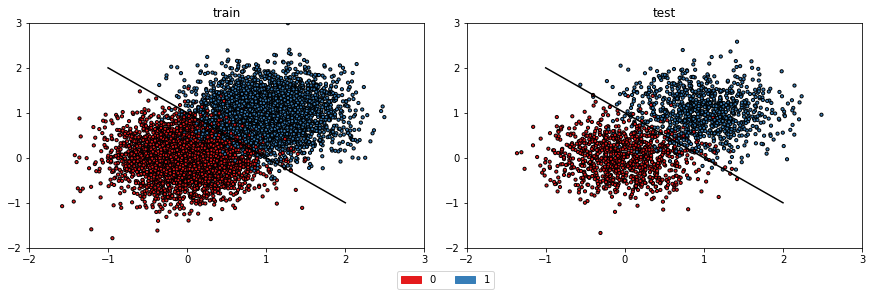

In [3]:
from valuation.utils.plotting import plot_datasets

datasets = {
    'train': train_ds,
    'test': test_ds,
}
x_min = np.asarray([-2, -2])
x_max = np.asarray([3, 3])
plot_datasets(datasets, x_min=x_min, x_max=x_max, line=decision_boundary, s=10)

Note that there are samples which go across the optimal decision boundary and will be wrongly labelled. The optimal decision boundary can not discriminate these as the mislabelling is a consequence of the presence of random noise.

## Training the model

We will now train a logistic regression model on the train data. This can be done with the following

In [4]:
model = TorchBinaryLogisticRegression(num_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
lr = 0.01
weight_decay = 0.05
batch_size=128

optimizer = AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train_loss, val_loss = model.fit(
    x_train = train_ds[0],
    y_train = train_ds[1].astype(float),
    x_val = val_ds[0],
    y_val = val_ds[1].astype(float),
    loss=F.binary_cross_entropy,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    batch_size=batch_size,
)

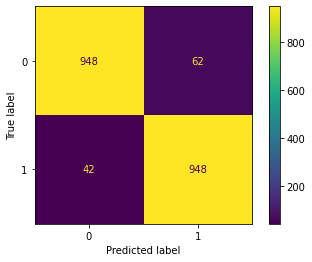

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_probabilities = model(test_ds[0]).detach()
pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]

cm = confusion_matrix(test_ds[1], pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

And let's check that the model is not overfitting

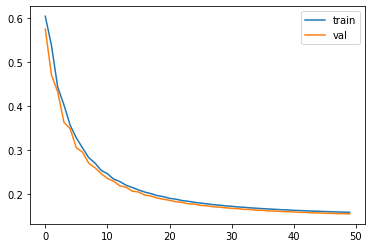

In [6]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

# Calculating influences

It is important that the model converges to a point near the optimum, since the influence values calculations assume that we are at a minimum (or close) in the loss landscape. The influence

$$I(x_1, y_1, x_2, y_2) \colon \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$$

measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$ trough some model parameters $\theta$. If the loss function L is differentiable (or can be approximated by a surrogate objective), we can take $I$ to be

$$
I(x_1, x_2) = \nabla_\theta\; L(x_1, y_1) ^\mathsf{T} \; H_\theta^{-1} \; \nabla_\theta \; L(x_2, y_2)
$$
See ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) for a detailed derivation of this formula

In pyDVL, the influence of the training points on the test points can be calculated with the following

In [38]:
from valuation.influence.general import influences
from copy import deepcopy
fake_y_train = deepcopy(train_ds[1])
fake_y_train[:10] = [1 if y==0 else 0 for y in fake_y_train[:10]]

train_influences = influences(
    model=model,
    loss=F.binary_cross_entropy,
    x_train = train_ds[0][:100],
    y_train = fake_y_train[:100].astype(float),
    x_test = test_ds[0],
    y_test = test_ds[1].astype(float),
    influence_type="up",
    inversion_method='direct', # use 'cg' for big models
)

The above explicitly constructions the Hessian. This can often be computationally expensive and conjugate gradient approximate calculation should be used for big models. 

With the influence type 'up', train influences have shape [NxM] where N is the number of test samples and M is the number of training samples. They therefore associate to each training sample its influence on each test sample. 
Influence type 'perturbation', instead, return an array of shape  [NxMxF], where F is the number of features in input, ie. the length of x. 

In our case, in order to have a value of the total average influence of a point we can just average across training samples.

In [39]:
mean_train_influences = np.mean(train_influences, axis=0)

Let's plot the result

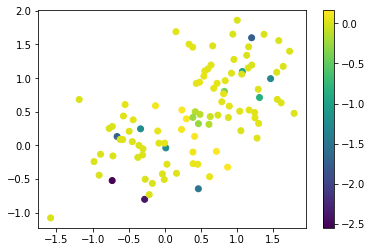

In [41]:
influence_datasets = {
    'train': (train_ds[0][:100], mean_train_influences),
}
plt.scatter(train_ds[0][:100][:, 0], train_ds[0][:100][:, 1], c=mean_train_influences)
plt.colorbar()

## Flipping 5% of the training dataset and restore almost 80% of the flipped samples

It is assumed that our reference test set is not flipped and was checked. Usually this is a viable solution as the test set is much smaller than the train set. First 5% of the training set get flipped at random positions. Second it is shown how to identify these examples. So a flipped dataset is created by

In [ ]:
from valuation.utils.dataset import flip_dataset

flipped_dataset, flipped_idx = flip_dataset(dataset, flip_percentage=0.05)

sampling random indices and inverting those. It is noteworthy to say that a new model has to fitted, because otherwise the old model contains information about the correct label of the specific data samples. Hence,

In [ ]:
from valuation.models import TorchModule, TorchOptimizer, TorchObjective
from valuation.models import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

flipped_model = TorchModule(
    model=BinaryLogisticRegressionTorchModel(num_features),
    objective=TorchObjective(F.binary_cross_entropy),
    num_epochs=100,
    batch_size=128,
    optimizer=TorchOptimizer.ADAM_W,
    optimizer_kwargs={
        "lr": 0.005,
        "weight_decay": 0.005
    },
)
flipped_model.fit(
    flipped_dataset.x_train,
    flipped_dataset.y_train
)

a new model is fitted with the pyDVL library. The newly obtained model is then used along with the flipped dataset to obtain the influences. Recall the aforementioned influence metrics and more specifically the mean absolute influence. For each training sample this metric is calculated and the 5% data points with the highest associated metric are extracted.

In [ ]:
flipped_train_test_influences = influences(
    flipped_model,
    flipped_dataset.x_train,
    flipped_dataset.y_train,
    flipped_dataset.x_test,
    flipped_dataset.y_test,
    influence_type=InfluenceTypes.Up
)
mean_flipped_train_test_influences = mean_influences(flipped_train_test_influences)
estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(flipped_idx)]
found_elements = set(estimated_idx).intersection(set(flipped_idx))
remaining_element = set(flipped_idx).difference(set(estimated_idx))
f"Around {100* len(found_elements) / len(flipped_idx):.2f}% could be identified. But there are {100* len(remaining_element) / len(flipped_idx):.2f}% remaining samples"

Furthermore, the accuracy is evaluated, e.g. the number of same elements in the ground truth and the detected samples. Depending on the dataset a detection of up to 80% percent could be achieved. One might further inspect the selection method for the indices as it only selects the highest influence points as flipped samples. Furthermore, it is unclear how flipping all samples back and retraining the model affects the loss of the initial dataset.


## Appendix: Calculating the decision boundary

For obtaining the optimal discriminator one has to solve the equation

$$p(x|y=0)=p(x|y=1)$$

and determine the solution set $X$. A closed-form solution can be found, if the pdf of both classes can be written in closed form. In the general case, this decision boundary must not be linear. However, in the case of two Gaussians

$$
\begin{align*}
p(x|y=0)&=\mathcal{N}\left (\mu_1, \sigma^2 I \right) \\
p(x|y=1)&=\mathcal{N}\left (\mu_2, \sigma^2 I \right)
\end{align*}
$$

the boundary is linear and is straightforward to derive it. The complete case with different full covariances is left to the reader as an exercise. For a single fixed diagonal variance parameterized by $\sigma$ the equation can be directly rewritten as

$$
\begin{align*}
\| x - \mu_1 \|^2 &= \| x - \mu_2 \|^2 \\
\| \mu_1 \|^2 -2 x^\mathsf{T} \mu_1 &= \| \mu_2 \|^2 -2 x^\mathsf{T} \mu_2 \\
\implies 0 &= 2 (\mu_2 - \mu_1)^\mathsf{T} x + \| \mu_1 \|^2 - \| \mu_2 \|^2 \\
0 &= \mu_1^\mathsf{T}x - \mu_2^\mathsf{T}x - \frac{1}{2} \mu_1^\mathsf{T} \mu_1 + \frac{1}{2} \mu_2^\mathsf{T} \mu_2
\end{align*}
$$

by using linear decision theory (see [Bishop C. 2006] for more details). However, this implicit description has to be transferred to an explicit one to effectively use it in python. Solving for the explicit form can be achieved by enforcing a functional form $f(z) = x = a z + b$ with $z \in \mathbb{R}$ onto $x$. After the term is inserted in the previous equation

$$
0 = (\mu_2 - \mu_1)^\mathsf{T} (az + b) + \frac{1}{2} \| \mu_1 \|^2 - \| \mu_2 \|^2
$$

by setting $a$ to be explicitly orthogonal to $\mu_2 - \mu_1$ and then solving for $b$ the solution

$$
f(z) = \underbrace{\begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} (\mu_2 - \mu_1)}_a z + \underbrace{\frac{\mu_1 + \mu_2}{2}}_b
$$

for the functional form $f(z) = a z + b$ can be obtained.

## Appendix B: Different influence aggregation methods

A few strictly positive sample metrics

$$
\begin{align*}
\text{MAI}(x) &= \frac{1}{N} \sum_{i=1}^N | I(x, x_i) | \\
\text{PMAI}(x) &= \frac{1}{N} \sum_{i=1}^N \max(0, I(x, x_i))  \\
\text{NMAI}(x) &= \frac{1}{N} \sum_{i=1}^N \max(0, -I(x, x_i))
\end{align*}
$$

are given. Note the functional relation $\text{MAI}(x) = \text{PMAI}(x) + \text{NMAI}(x)$.